In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
plt.style.use('fivethirtyeight')
import xgboost as xgb
print("xgboost", xgb.__version__)
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

xgboost 1.3.3


In [2]:
df = pd.read_csv("data/avocado.csv")

In [3]:
data = df.copy()

In [4]:
data = data.drop(['Unnamed: 0'],axis = 1)

In [5]:
data.Date

0        2015-12-27
1        2015-12-20
2        2015-12-13
3        2015-12-06
4        2015-11-29
            ...    
18244    2018-02-04
18245    2018-01-28
18246    2018-01-21
18247    2018-01-14
18248    2018-01-07
Name: Date, Length: 18249, dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [7]:
data.describe(include = 'all')

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,18249,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249,18249.000000,18249
unique,169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,54
top,2017-10-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conventional,NaN,HarrisburgScranton
freq,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9126,NaN,338
mean,NaN,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,NaN,2016.147899,NaN
std,NaN,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,NaN,0.939938,NaN
min,NaN,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,2015.000000,NaN
25%,NaN,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,NaN,2015.000000,NaN
50%,NaN,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,NaN,2016.000000,NaN
75%,NaN,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,NaN,2017.000000,NaN


In [8]:
data["Date"] = pd.to_datetime(data["Date"])
data["month"] = data["Date"].dt.month
data["day"] = data["Date"].dt.day


In [9]:


scatter = go.Scatter(x = data.groupby('Date').mean().index, y = data.groupby('Date').mean().AveragePrice , name = 'avg price')

layout = go.Layout(title = 'Time series plot for mean daily prices for all regions', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter], layout = layout)
iplot(figure)

In [10]:
#renaming columns

rename_columns = list(data.columns)
rename_columns = [x.lower() for x in rename_columns]
data.columns = rename_columns
data = data.rename(columns = lambda x: x.replace(' ','_'))

In [11]:
data

,date,averageprice,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,region,month,day
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,2,4
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,1,28
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,1,21
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,1,14


In [12]:



#Tranforming categorical values 

def label_enconcode_pre(df):
    if df.dtype == 'object':
        df = LabelEncoder().fit_transform(df)
    return df

data = data.apply(lambda x: label_enconcode_pre(x))

In [13]:
data = pd.get_dummies(data, columns=['year','type','region'], drop_first= True)

In [14]:
data = data.set_index('date')

In [15]:
split_date = '2017-07-30'
data_train = data.loc[data.index <= split_date]
data_test = data.loc[data.index > split_date]

scatter = go.Scatter(x = data_train.groupby('date').mean().index, y = data_train.groupby('date').mean().averageprice , name = 'train')
scatter2 = go.Scatter(x = data_test.groupby('date').mean().index, y = data_test.groupby('date').mean().averageprice, name = 'test')

layout = go.Layout(title = 'Time series plot for mean daily prices for all regions', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

In [16]:
# Train / Test split

X_train = data_train.drop(['averageprice'], axis = 1)
y_train = data_train['averageprice']

X_test = data_test.drop(['averageprice'], axis = 1)
y_test = data_test['averageprice']

### XGBoost model 

In [17]:


reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False, ) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

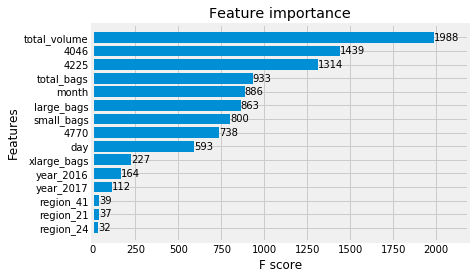

In [18]:

plot_importance(reg, height=0.8, max_num_features=15)

In [19]:
data_test["averageprice_prediction"] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
data_all[['averageprice', 'averageprice_prediction']].sort_values('date')

,averageprice,averageprice_prediction
date,,
2015-01-04,1.75,NaN
2015-01-04,1.83,NaN
2015-01-04,1.22,NaN
2015-01-04,1.64,NaN
2015-01-04,0.89,NaN
...,...,...
2018-03-25,1.21,1.188677
2018-03-25,1.37,1.037628
2018-03-25,1.45,1.316828


In [21]:
scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'XGBoost time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)

### Metrics

In [22]:
mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

MAE: 0.20786316818920875 MSE: 0.07615221729286288


### Fine tuning the model  

In [27]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["rmse"]
%time reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

Wall time: 36.5 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.09, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.09, max_depth = 8)
reg.fit(X_train, y_train,
        eval_set=eval_set,
        early_stopping_rounds=50,
       verbose=False, )

data_test["averageprice_prediction"] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort = False)

scatter = go.Scatter(x = data.groupby('date').mean().index, y = data.groupby('date').mean().averageprice , name = 'actual')
scatter2 = go.Scatter(x = data_all.groupby('date').mean().index, y = data_all.groupby('date').mean().averageprice_prediction, name = 'forecast')

layout = go.Layout(title = 'XGBoost time series forecast', xaxis ={'title':'Date'}, yaxis = {'title':'Prices'})
figure = go.Figure(data = [scatter, scatter2], layout = layout)
iplot(figure)


mse = mean_squared_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])
mae = mean_absolute_error(y_true=data_test['averageprice'], y_pred=data_test['averageprice_prediction'])

print("MAE:", mae, "MSE:",mse)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE: 0.20315506900058072 MSE: 0.07366058699490972
